# Branch evolution

William Albert, Hannah Weiser, July 2025 

This notebook demonstrates the preparation of the 4DGeo branch evolution example. The dataset contains **weekly scans of a tree** over a time period of **6 weeks**, with the first scan on 27 March 2025 and the last scan on 9 May 2025.

The starting point of the notebook are pointwise motion vectors computed for all pairs of consecutive scans. These may be computed using tools like [PlantMove](https://doi.org/10.1016/j.jag.2022.102781). Here, we read these motion vectors from a .npz file with Python. In addition, we have .laz files for the individual scans, which for each epoch are split into the branch of interest and the rest of the tree. 

## Imports

In [1]:
import os
import sys
import json

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import pandas as pd
import laspy

import vapc
from vapc.las_split_append_merge import las_merge
sys.path.insert(0, "../src")
from fourdgeo import projection
from fourdgeo import utilities

# File import and handling
from pathlib import Path
import zipfile, urllib.request, shutil
from glob import glob

# Image and geometry handling
from PIL import Image, ImageDraw, ImageFont
from IPython.display import HTML
from shapely.geometry import shape

## Getting the data

In [2]:
data_url = "https://heibox.uni-heidelberg.de/f/de3dc527cb3f478f896e/?dl=1"
file_name = "branch_evolution.zip"
data_folder = "data/branch_evolution"

with urllib.request.urlopen(data_url) as response, open(file_name, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall(data_folder)

# Deleting the .zip file
os.remove(file_name)

## Overview of the data

Let's first get an overview of the input data. We visualize the point clouds of the first and last scan side by side with `matplotlib` by height, showing the branch of interest in black.

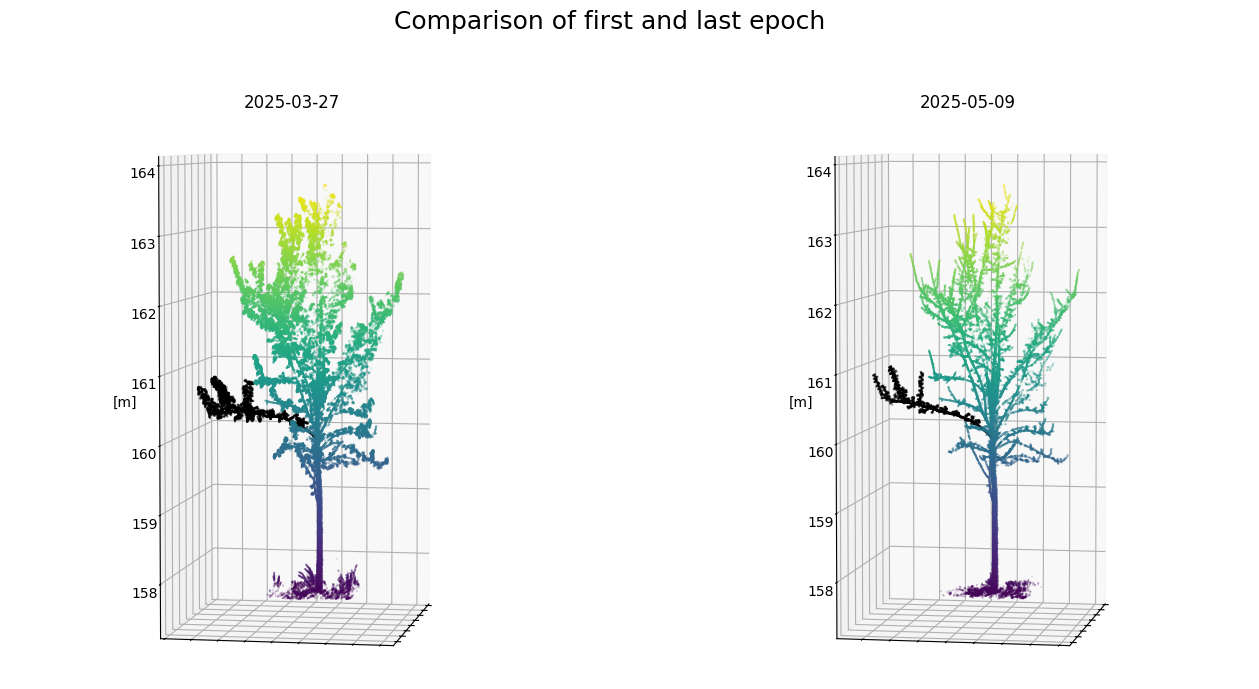

In [3]:
laz_files_branches = list(Path(data_folder).glob("*_branch.laz"))
laz_files_rest = list(Path(data_folder).glob("*_rest.laz"))

las_b0 = laspy.read(laz_files_branches[0])
pc_b0 = np.c_[las_b0.x, las_b0.y, las_b0.z]
las_b6 = laspy.read(laz_files_branches[6])
pc_b6 = np.c_[las_b6.x, las_b6.y, las_b6.z]
las_r0 = laspy.read(laz_files_rest[0])
pc_r0 = np.c_[las_r0.x, las_r0.y, las_r0.z]
las_r6 = laspy.read(laz_files_rest[6])
pc_r6 = np.c_[las_r6.x, las_r6.y, las_r6.z]

fig = plt.figure(figsize=(16,8))

# Scatter plot
ax = fig.add_subplot(121, projection="3d")
sc1 = ax.scatter(
    pc_b0[::5, 0],
    pc_b0[::5, 1],
    pc_b0[::5, 2],
    color="black", s=0.02
)
sc1_2 = ax.scatter(
    pc_r0[::5, 0],
    pc_r0[::5, 1],
    pc_r0[::5, 2],
    c=pc_r0[::5, 2], s=0.02
)

ax2 = fig.add_subplot(122, projection="3d")
sc2 = ax2.scatter(
    pc_b6[::5, 0],
    pc_b6[::5, 1],
    pc_b6[::5, 2],
    color="black", s=0.02
)
sc2_2 = ax2.scatter(
    pc_r6[::5, 0],
    pc_r6[::5, 1],
    pc_r6[::5, 2],
    c=pc_r6[::5, 2], s=0.02
)

# Add axis labels.
ax.set_zlabel("[m]")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title("2025-03-27")
ax2.set_zlabel("[m]")
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_title("2025-05-09")

# set equal axes
box = (np.ptp(pc_r6[:, 0]), np.ptp(pc_r6[:, 1]), np.ptp(pc_r6[:, 2]))
ax.set_box_aspect(box)
ax2.set_box_aspect(box)

# Set title.
# Set view
ax.view_init(elev=5, azim=10, roll=0)
ax2.view_init(elev=5, azim=10, roll=0)

# Display results
fig.suptitle("Comparison of first and last epoch", fontsize=18)
plt.show()

The motion vectors have been computed with [PlantMove](https://doi.org/10.1016/j.jag.2022.102781) for each point in a selected branch in the point cloud. They are stored in a .npz archive. Let's look at the structure for the first observation (change between first epoch on 27 March and second epoch on 4 April 2025).

`cloud_x` is the first time step, \
`cloud_y` is the second time step, \
`motionfield` is the derived motion field \
and `cloud_new` is the point cloud of the second time step registered onto the first time step by applying the motion vectors.

In [4]:
files = list(Path(data_folder).glob("*.npz"))
files = sorted(files)
obs_file = files[0]
data = np.load(obs_file)
cloud_x = data["x_original"]  # t0
cloud_y = data["y_original"]  # t1
cloud_new = data["y_new"]  # t1 to t0
motionfield = data["motionfield"]  # motion field from t0 to t1
motion_vec = motionfield[:, 3:6]
motion_magnitudes = np.linalg.norm(motion_vec, axis=1)

In [5]:
print("Motion magnitudes between t0 and t1:\n")
print(f"{'Min:':20} {motion_magnitudes.min():.3f} m")
print(f"{'Max:':20} {motion_magnitudes.max():.3f} m")
print(f"{'Mean:':20} {motion_magnitudes.mean():.3f} m")
print(f"{'Standard deviation:':20} {motion_magnitudes.std():.3f} m")

Motion magnitudes between t0 and t1:

Min:                 0.000 m
Max:                 0.018 m
Mean:                0.005 m
Standard deviation:  0.003 m


## Creating the 2D background images

For each observation, we create a 2D image of the point cloud by projecting the 3D points onto a 2D plane from the viewpoint of the scanner. Before that, we need to prepare the data accordingly.

### Prepare the configuration dictionary

We use a configuration dictionary that contains general project settings like the `output_folder` and the relevant settings for the point cloud projection. For the projection, the `camera_position` is essential, for which we choose the location of the scanner (in ETRS89, UTM zone 32 N).

In [6]:
configuration = {
    "project_setting": {
        "project_name": "Branch_evolution",
        "output_folder": "./out",
        "temporal_format": "%y%m%d_%H%M%S",
        "silent_mode": True,
        "include_timestamp": False
    },
    "pc_projection": {
        "pc_path": "",
        "make_range_image": False,
        "make_color_image": True,
        "top_view": False,
        "save_rot_pc": False,
        "resolution_cm": 0.2,
        "camera_position": [
            475923.4099,
            5473923.7662,
            159.1088
        ],
        "rgb_light_intensity": 100,
        "range_light_intensity": 60,
        "epsg": 25832
    }
}

### Merging each branch with its respective tree

In our input data, point clouds of the branch of interest are separated from the rest of the tree.
For each epoch, we merge 
1) The branch point cloud of the epoch (coloured in red),
2) The branch point cloud of the next epoch (coloured in blue)
3) The point cloud of the remaining tree at the epoch (coloured in grayscale by intensity)

In [7]:
laz_files_rest = sorted(laz_files_rest)
laz_files_branches = sorted(laz_files_branches)

pcs = []

for enum in np.arange(len(laz_files_rest)-1):
    pos = str(laz_files_rest[enum]).find("_icp_rest")
    new_file_path = str(laz_files_rest[enum])[:pos]
    with laspy.open(laz_files_branches[enum]) as las_branch_A:
        las_branch_A = las_branch_A.read()
        las_branch_A.red = np.full(len(las_branch_A.points), 65535)
        las_branch_A.green = np.full(len(las_branch_A.points), 22768)
        las_branch_A.blue = np.full(len(las_branch_A.points), 0)
        las_branch_A.write(laz_files_branches[enum])

    with laspy.open(laz_files_branches[enum+1]) as las_branch_B:
        las_branch_B = las_branch_B.read()
        las_branch_B.red = np.full(len(las_branch_B.points), 0)
        las_branch_B.green = np.full(len(las_branch_B.points), 0)
        las_branch_B.blue = np.full(len(las_branch_B.points), 65535)
        las_branch_B.write(laz_files_branches[enum+1])

    with laspy.open(laz_files_rest[enum]) as las_rest_A:
        las_rest_A = las_rest_A.read()
        intensities = las_rest_A.intensity

        # Normalize intensities to 0-65535
        norm = (intensities - intensities.min()) / (np.ptp(intensities) + 1e-8)
        colors = (norm * 65535).astype(np.uint16)

        # Assign grayscale color based on intensity
        las_rest_A.red = las_rest_A.green = las_rest_A.blue = colors
        las_rest_A.write(laz_files_rest[enum])

    las_merge([laz_files_rest[enum], laz_files_branches[enum], laz_files_branches[enum+1]], f"{new_file_path}_{enum}_{enum+1}.laz", point_source_id=True)
    pcs.append(f"{new_file_path}_{enum}_{enum+1}.laz")

### Projecting the point clouds onto 2D images

We now generate the background images. For this, we are using classes and functions from the `fourdgeo` library. The `PCloudProjection` directly takes our configuration file as input. 

In [ ]:
images = []
list_background_projections = []

for enum, pc in enumerate(pcs):
    lf = laspy.read(pc)
    configuration['pc_projection']['pc_path'] = pc
    project_name = configuration['project_setting']['project_name']
    output_folder = configuration['project_setting']['output_folder']
    
    background_projection = projection.PCloudProjection(
        configuration = configuration,
        project_name = project_name,
        projected_image_folder = output_folder
    )
    # First projection
    if enum == 0:
        (
            ref_h_fov, ref_v_fov, ref_anchor_point_xyz, 
            ref_h_img_res, ref_v_img_res
        ) = background_projection.project_pc(buffer_m = 0.5)
    # Next projections using reference data
    else:
        background_projection.project_pc(
            ref_theta=ref_h_fov[0],
            ref_phi=ref_v_fov[0],
            ref_anchor_point_xyz=None,
            ref_h_fov=ref_h_fov,
            ref_v_fov=ref_v_fov,
            ref_h_img_res=ref_h_img_res,
            ref_v_img_res=ref_v_img_res
        )

    bg_img = background_projection.bg_image_filename[0]
    if bg_img[0] == ".":
        bg_img = bg_img[2:]

    outfile = bg_img.split('.')[0] + f"_{enum}_{enum+1}." + bg_img.split('.')[1]
    to_replace = glob(f"{output_folder}/{project_name}_*Image.tif")[0]

    try:
        os.rename(bg_img, outfile)
    except FileExistsError:
        os.remove(outfile)
        os.rename(bg_img, outfile)

    images.append(outfile)

    background_projection.bg_image_filename[0] = outfile
    list_background_projections.append(background_projection)

Let's create a GIF from the images and display it.

In [9]:
gif_path = "../docs/img/tree_projections.gif"
frames = [Image.open(img).convert("RGB") for img in images]

frames[0].save(
    gif_path,
    save_all=True,
    append_images=frames[1:],
    duration=500,
    loop=0
)

HTML(f"""
<img src="{gif_path}" style="height:6in;" />
""")

## Deriving a subset of motion vectors by voxelization and projecting them to 2D image coordinates

Since the visualization would be too cluttered with all motion vectors, we reduce the number of motion vectors by voxelizing the point cloud and only keeping one motion vector per voxel. We write this motion vector as a dictionary into a list `observations`.

In [10]:
if configuration["project_setting"]["silent_mode"]:
    vapc.enable_trace(False)
    vapc.enable_timeit(False)
voxel_size = 0.05

In [11]:
project_name = configuration["project_setting"]["project_name"]
observations = {"observations": []}

for epoch_id, file in enumerate(files):
    geoObjects = []
    # extract time from filenames
    t_min = utilities.iso_timestamp("_".join(file.stem.split("_")[1:3]))
    t_max = utilities.iso_timestamp("_".join(file.stem.split("_")[7:9]))

    data = np.load(file)
    cloud_x = data["x_original"]  # t0
    cloud_y = data["y_original"]  # t1
    cloud_new = data["y_new"]  # t1 to t0
    motionfield = data["motionfield"]
    motion_vec = motionfield[:, 3:6]
    motion_magnitudes = np.linalg.norm(motion_vec, axis=1)

    if epoch_id == 0:
        min_point = np.min(cloud_x, axis=0)
        local_origin = np.floor(min_point / 100) * 100
    
    # array to dataframe
    df_y = pd.DataFrame(cloud_y, columns=["X", "Y", "Z"])
    df_new = pd.DataFrame(cloud_new, columns=["X", "Y", "Z"])

    vapc_y = vapc.Vapc(voxel_size=voxel_size, origin=local_origin.tolist())
    vapc_y.df = df_y
    vapc_y.compute = ["center_of_voxel"]
    vapc_y.compute_requested_attributes()

    vapc_new = vapc.Vapc(voxel_size=voxel_size, origin=local_origin.tolist())
    vapc_new.df = df_new
    vapc_new.compute = ["center_of_voxel"]
    vapc_new.compute_requested_attributes()
    
    if epoch_id == 0:
        seed_points = np.array((vapc_new.df["center_x"].values, vapc_new.df["center_y"].values, vapc_new.df["center_z"].values)).T
        seed_points = np.unique(seed_points, axis=0)
    else:
        seed_points = pts_y_original
    
    # get nearest neighbours to seed points in cloud_new
    tree_ynew = KDTree(cloud_new)

    dist, idx_yn = tree_ynew.query(seed_points, k=1)

    # get points
    pts_y_original = cloud_y[idx_yn, :]
    pts_y_new = cloud_new[idx_yn, :]

    # create lines from nearest points to seed in cloud y and corresponding points in cloud x
    lines = np.hstack((pts_y_original, pts_y_new))

    # create json object for each line
    for i in range(lines.shape[0]):
        geoObject = {}
        geoObject["id"] = f"{epoch_id}{i:04d}"
        geoObject["type"] = "motion_vector"
        geoObject["dateTime"] = t_min
        geoObject["geometry"] = {
            "type": "",
            "coordinates": [
                lines[i, 0:3].tolist(),
                lines[i, 3:6].tolist()
            ]
        }
        geoObject["customEntityData"] = {
            "motion_magnitudes": motion_magnitudes[i],
            "epoch_id": epoch_id
        }
        
        geoObjects.append(geoObject)

    observations["observations"].append({
        "startDateTime": t_min,
        "endDateTime": t_max,
        "geoObjects": geoObjects,
        "backgroundImageData": {
            "url": list_background_projections[epoch_id].bg_image_filename[0],
            "height": Image.open(images[epoch_id]).convert("RGB").size[1],
            "width": Image.open(images[epoch_id]).convert("RGB").size[0]
        },
    })

## Projecting the vectors from each observation onto their respective figure

Finally, we also project these motion vectors onto the 2D image plane and save them in geoJSON files, together with the projected images. These files can then be loaded with the 4DGeo Dashboard.

In [ ]:
list_observation_projection = []
for epoch_id, observation in enumerate(observations['observations']):
    background_projection = list_background_projections[epoch_id]

    observation_projection = projection.ProjectChange(observation=observation,
                            project_name=f"{project_name}_{epoch_id}_{epoch_id+1}",
                            projected_image_path=background_projection.bg_image_filename[0],
                            projected_events_folder="./out",
                            epsg=None)

    observation_projection.project_change()
    list_observation_projection.append(observation_projection)

Let's display the branch (projected image) and the motion vectors in another GIF.

In [13]:
branch_crop_box = (130, 1170, 1600, 2000) # (left, upper, right, lower)
frames = []
gif_path = "../docs/img/tree_projections_plus_observations.gif"
font = ImageFont.load_default(size = 50)

for enum, img in enumerate(images):
    frm = Image.open(img).convert("RGB")
    frm = frm.crop(branch_crop_box)
    draw = ImageDraw.Draw(frm)
    draw.text((50, 50), f"Epoch: {enum}", fill=(255, 255, 255), font=font)

    observation_projection = list_observation_projection[enum]

    # Load geojson
    with open(observation_projection.geojson_name, 'r') as f:
        geojson_data = json.load(f)

    for feature in geojson_data["features"]:
        geom = shape(feature["geometry"])
        coords = [(int(x) - branch_crop_box[0], -int(y) - branch_crop_box[1]) for x, y in geom.coords]
        draw.line(coords, fill="yellow", width=2)

    frames.append(frm)
    

frames[0].save(
    gif_path,
    save_all=True,
    append_images=frames[1:],
    duration=600,
    loop=0
)

# Bust cache with a unique query string
gif_display_path = gif_path + "?v=" + str(os.path.getmtime(gif_path))
HTML(f"""
<img src="{gif_display_path}" style="height:5in;" />
""")